In [15]:
import torch
torch.set_default_dtype(torch.double)
from torchfem import Planar

In [16]:
# The 'classic' 60x20 2d mbb beam, as per Ole Sigmund's 99 line code.
config = {
    "ETA": "0.5",
    "FILT_RAD": 1.5,
    "FXTR_NODE_X": range(1, 22),
    "FXTR_NODE_Y": 1281,
    "LOAD_NODE_Y": 1,
    "LOAD_VALU_Y": -1,
    "NUM_ELEM_X": 60,
    "NUM_ELEM_Y": 20,
    "NUM_ELEM_Z": 0,
    "NUM_ITER": 94,
    "P_FAC": 3.0,
    "VOL_FRAC": 0.5,
}

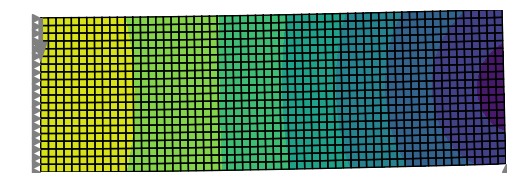

In [17]:
Nx = config["NUM_ELEM_X"]
Ny = config["NUM_ELEM_Y"]

# Create nodes
n1 = torch.linspace(0.0, Nx, Nx + 1)
n2 = torch.linspace(Ny, 0.0, Ny + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="ij"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(Ny):
    for i in range(Nx):
        n0 = j + i * (Ny + 1)
        elements.append([n0, n0 + 1, n0 + Ny + 2, n0 + Ny + 1])

# Load at top
forces = torch.zeros_like(nodes)
forces[torch.tensor(config["LOAD_NODE_Y"])-1, 1] = config["LOAD_VALU_Y"]

# Constrained displacement at left end
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[torch.tensor(config["FXTR_NODE_X"])-1, 0] = True
constraints[torch.tensor(config["FXTR_NODE_Y"])-1, 1] = True

# Thickness
thickness = torch.ones(len(elements))

# Material model (plane stress)
E = 100.0
nu = 0.3
C = (E / ((1.0 + nu) * (1.0 - 2.0 * nu))) * torch.tensor(
    [[1.0 - nu, nu, 0.0], [nu, 1.0 - nu, 0.0], [0.0, 0.0, 0.5 - nu]]
)

# Create and plot the domain
model = Planar(nodes, elements, forces, constraints, thickness, C)
u, f = model.solve()
model.plot(u=u, node_property=torch.linalg.norm(u, dim=1))

In [18]:
rho_0 = config["VOL_FRAC"] * torch.ones(len(elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = torch.ones_like(rho_0)
move = 0.2
V_0 = config["VOL_FRAC"] * Nx * Ny 
k0 = torch.einsum("i,ijk->ijk", 1.0 / model.thickness, model.k())

In [19]:
def bisection(f, a, b, max_iter=50, tol=1e-12):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

In [20]:
rho = [rho_0]
p = config["P_FAC"]

# # Precompute filter weights
if config["FILT_RAD"] > 0.0:
    ecenters = torch.stack([torch.mean(nodes[e], dim=0) for e in elements])
    dist = torch.cdist(ecenters, ecenters)
    H = config["FILT_RAD"] - dist
    H[dist > config["FILT_RAD"]] = 0.0

# Iterate solutions
for k in range(config["NUM_ITER"]):
    # Adjust thickness variables
    model.thickness = rho[k] ** p

    # Compute solution
    u_k, f_k = model.solve()

    # Compute analytical sensitivities
    u_j = u_k[elements].reshape(model.n_elem, -1)
    w_k = torch.einsum("...i, ...ij, ...j", u_j, k0, u_j)
    sensitivity = - p * rho[k] ** (p - 1.0) * w_k

    # Filter sensitivities (if r provided)
    if config["FILT_RAD"] > 0.0:
        sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

    # For a certain value of mu, apply the iteration scheme
    def make_step(mu):
        G_k = -sensitivity / mu 
        upper = torch.min(rho_max, (1 + move) * rho[k])
        lower = torch.max(rho_min, (1 - move) * rho[k])
        rho_trial = G_k**0.5 * rho[k]
        return torch.maximum(torch.minimum(rho_trial, upper), lower)

    # Constraint function
    def g(mu):
        rho_k = make_step(mu)
        return rho_k.sum() - V_0

    # Find the root of g(mu)
    mu = bisection(g, 1e-10, 100.0)
    
    # Evaluation
    compliance = torch.inner(f_k.ravel(), u_k.ravel())
    print(f"Iteration k={k} - Compliance: {compliance:.5f}")

    rho.append(make_step(mu))


Iteration k=0 - Compliance: 9.16104
Iteration k=1 - Compliance: 6.28342
Iteration k=2 - Compliance: 4.80509
Iteration k=3 - Compliance: 3.86055
Iteration k=4 - Compliance: 3.24614
Iteration k=5 - Compliance: 3.04871
Iteration k=6 - Compliance: 2.93244
Iteration k=7 - Compliance: 2.83243
Iteration k=8 - Compliance: 2.73582
Iteration k=9 - Compliance: 2.63700
Iteration k=10 - Compliance: 2.53660
Iteration k=11 - Compliance: 2.42932
Iteration k=12 - Compliance: 2.31388
Iteration k=13 - Compliance: 2.20253
Iteration k=14 - Compliance: 2.12295
Iteration k=15 - Compliance: 2.06585
Iteration k=16 - Compliance: 2.02312
Iteration k=17 - Compliance: 1.99034
Iteration k=18 - Compliance: 1.96587
Iteration k=19 - Compliance: 1.94854
Iteration k=20 - Compliance: 1.93399
Iteration k=21 - Compliance: 1.92066
Iteration k=22 - Compliance: 1.90879
Iteration k=23 - Compliance: 1.89900
Iteration k=24 - Compliance: 1.89102
Iteration k=25 - Compliance: 1.88462
Iteration k=26 - Compliance: 1.88093
Iteration k

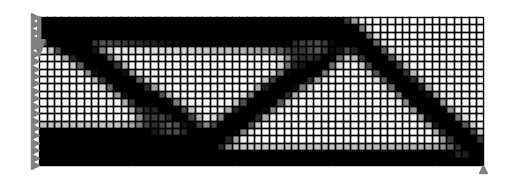

In [21]:
model.plot(element_property=rho[-1], cmap="gray_r")